# Lab 04: PyTorch를 이용한 로지스틱 회귀 (Logistic Regression)

이 노트북에서는 다음을 수행합니다:
1. 공부한 시간(x)과 합격/불합격(y) 데이터 사용
2. PyTorch `nn.Sequential`을 사용해 간단한 로지스틱 회귀 모델 생성
3. Adam Optimizer를 사용한 모델 학습
4. 1000 epoch 동안 loss가 줄어드는 과정 시각화
5. 결정 경계(Decision Boundary) 시각화

### Prompt
PyTorch로 간단한 선형회귀 코드를 만드는 것이 목표입니다.

1. 공부한 시간(x)과 성적(y) 데이터를 임의로 생성하고 

2. PyTorch nn.Linear를 사용해 선형회귀 층을 만들고 

3. Adam Optimizer를 사용하라. 

4. 1000 epoch 학습키키면사 loss가 줄어드는 과정을 시각화 해줘 

5. 생성한 코드는 Lab03.ipynb로 저장해줘

In [ ]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 재현성을 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)

## 1. 데이터 준비

공부한 시간(x)과 합격/불합격(y) 데이터를 정의합니다.
- x: 공부 시간 [1, 3, 3.5, 5, 7, 9.5, 12, 15] 시간
- y: 합격(1) / 불합격(0) [0, 0, 0, 1, 1, 1, 1, 1]

In [16]:
# 데이터 정의: 공부한 시간(x)과 합격/불합격(y)
x = np.array([[1], [3], [3.5], [5], [7], [9.5], [12], [15]], dtype=np.float32)
y = np.array([[0], [0], [0], [1], [1], [1], [1], [1]], dtype=np.float32)

# NumPy 배열을 PyTorch 텐서로 변환
x_tensor = torch.FloatTensor(x)
y_tensor = torch.FloatTensor(y)

num_samples = len(x)

print(f"Data shape: x={x_tensor.shape}, y={y_tensor.shape}")
print(f"Study hours range: {x_tensor.min():.2f} ~ {x_tensor.max():.2f} hours")
print(f"Pass count: {y_tensor.sum().item():.0f}, Fail count: {(num_samples - y_tensor.sum()).item():.0f}")
print(f"\nData:")
print(f"x = {x.flatten().tolist()}")
print(f"y = {y.flatten().tolist()}")

Data shape: x=torch.Size([8, 1]), y=torch.Size([8, 1])
Study hours range: 1.00 ~ 15.00 hours
Pass count: 5, Fail count: 3

Data:
x = [1.0, 3.0, 3.5, 5.0, 7.0, 9.5, 12.0, 15.0]
y = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]


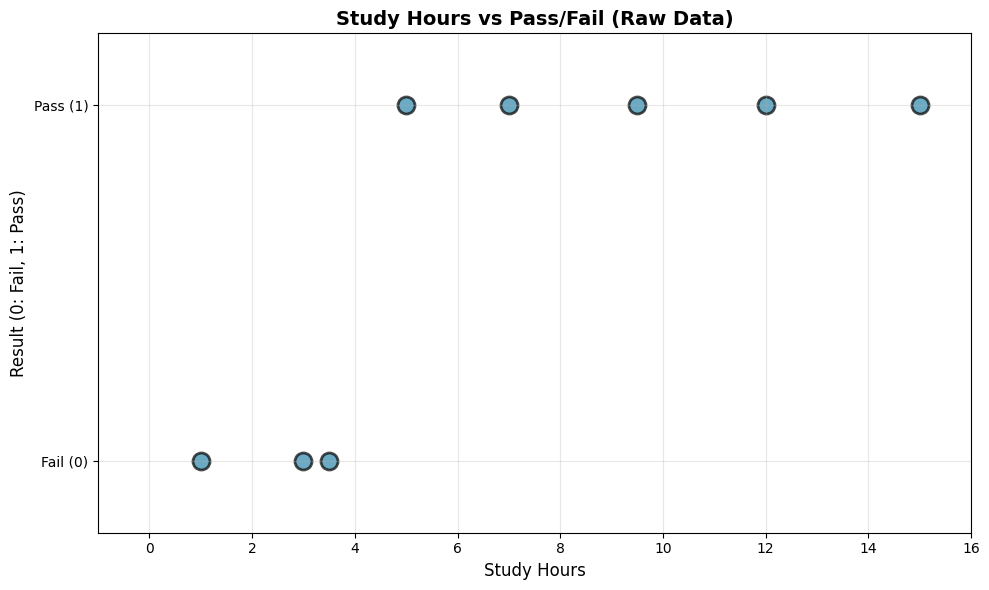

In [17]:
# 생성된 데이터 시각화 (원본 데이터 그대로)
plt.figure(figsize=(10, 6))

# 모든 데이터를 하나의 산점도로 표시
plt.scatter(x, y, alpha=0.7, s=150, edgecolors='black', linewidth=2, color='#2E86AB')

plt.xlabel('Study Hours', fontsize=12)
plt.ylabel('Result (0: Fail, 1: Pass)', fontsize=12)
plt.title('Study Hours vs Pass/Fail (Raw Data)', fontsize=14, fontweight='bold')
plt.yticks([0, 1], ['Fail (0)', 'Pass (1)'])
plt.xlim(-1, 16)
plt.ylim(-0.2, 1.2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. 로지스틱 회귀 모델 정의

`nn.Sequential`을 사용하여 간단하게 모델을 정의합니다.
- Linear: 선형 변환 (wx + b)
- Sigmoid: 0~1 사이의 확률로 변환

In [18]:
# 로지스틱 회귀 모델 정의 (nn.Sequential 사용)
model = nn.Sequential(
    nn.Linear(1, 1),  # 입력: 1 (공부 시간), 출력: 1 (로짓)
    nn.Sigmoid()      # 0~1 사이의 확률로 변환
)

print("Model structure:")
print(model)
print("\nInitial parameters:")
print(f"Weight: {model[0].weight.item():.4f}")
print(f"Bias: {model[0].bias.item():.4f}")

Model structure:
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Sigmoid()
)

Initial parameters:
Weight: -0.2343
Bias: 0.9186


## 3. 손실 함수와 옵티마이저 설정

- **손실 함수**: BCELoss (Binary Cross Entropy Loss) - 이진 분류 문제에 적합
- **옵티마이저**: Adam - 학습률을 자동으로 조정하는 효율적인 옵티마이저

In [19]:
# 손실 함수: BCELoss (Binary Cross Entropy Loss)
criterion = nn.BCELoss()

# 옵티마이저: Adam
# lr=0.01: 학습률 (learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


## 4. 모델 학습

1000 epoch 동안 모델을 학습하고 loss를 기록합니다.

In [20]:
# 학습 설정
num_epochs = 1000
loss_history = []  # loss 기록을 위한 리스트

# 학습 루프
for epoch in range(num_epochs):
    # 1. Forward pass: 예측값 계산 (합격 확률)
    predictions = model(x_tensor)
    
    # 2. 손실 계산
    loss = criterion(predictions, y_tensor)
    
    # 3. Backward pass: 그래디언트 계산
    optimizer.zero_grad()  # 이전 그래디언트 초기화
    loss.backward()  # 역전파로 그래디언트 계산
    
    # 4. 파라미터 업데이트
    optimizer.step()
    
    # 5. Loss 기록
    loss_history.append(loss.item())
    
    # 100 epoch마다 진행 상황 출력
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("\nTraining completed!")
print(f"\nFinal parameters:")
print(f"Weight: {model[0].weight.item():.4f}")
print(f"Bias: {model[0].bias.item():.4f}")

Epoch [100/1000], Loss: 0.5331
Epoch [200/1000], Loss: 0.3970
Epoch [300/1000], Loss: 0.3144
Epoch [400/1000], Loss: 0.2618
Epoch [500/1000], Loss: 0.2259
Epoch [600/1000], Loss: 0.1996
Epoch [700/1000], Loss: 0.1794
Epoch [800/1000], Loss: 0.1632
Epoch [900/1000], Loss: 0.1498
Epoch [1000/1000], Loss: 0.1385

Training completed!

Final parameters:
Weight: 1.0235
Bias: -4.3480


## 5. Loss 감소 과정 시각화

1000 epoch 동안 loss가 어떻게 감소하는지 시각화합니다.

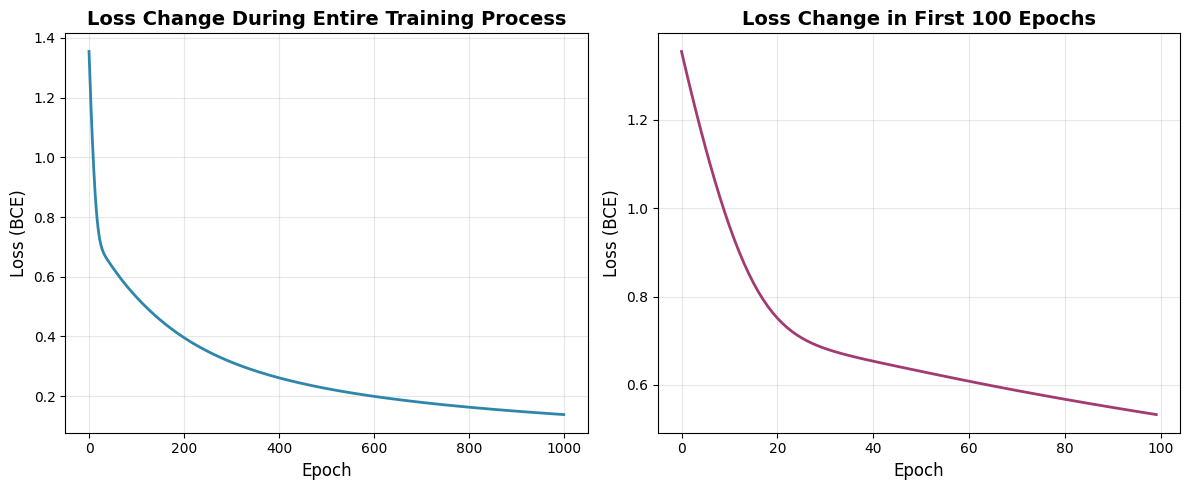

Initial Loss: 1.3544
Final Loss: 0.1385
Loss Reduction Rate: 89.78%


In [21]:
# Loss 감소 과정 시각화
plt.figure(figsize=(12, 5))

# 전체 loss 그래프
plt.subplot(1, 2, 1)
plt.plot(loss_history, linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE)', fontsize=12)
plt.title('Loss Change During Entire Training Process', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 처음 100 epoch의 loss (초기 학습 과정 확대)
plt.subplot(1, 2, 2)
plt.plot(loss_history[:100], linewidth=2, color='#A23B72')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (BCE)', fontsize=12)
plt.title('Loss Change in First 100 Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial Loss: {loss_history[0]:.4f}")
print(f"Final Loss: {loss_history[-1]:.4f}")
print(f"Loss Reduction Rate: {(1 - loss_history[-1]/loss_history[0]) * 100:.2f}%")

## 6. 학습 결과 시각화 (확률 곡선)

학습된 모델의 합격 확률 곡선을 시각화합니다.

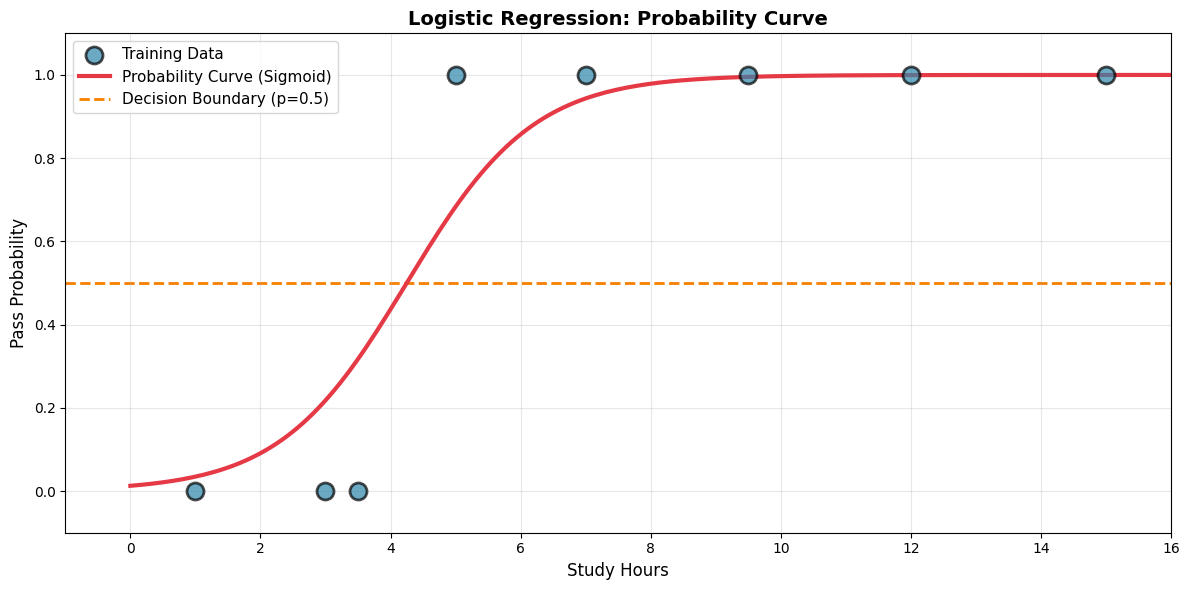

In [22]:
# 학습된 모델로 예측
model.eval()  # 평가 모드로 전환

# 0~16시간 범위에서 확률 곡선 그리기
x_range = np.linspace(0, 16, 200).reshape(-1, 1)
with torch.no_grad():  # 그래디언트 계산 비활성화
    prob_curve = model(torch.FloatTensor(x_range)).numpy()

# 결과 시각화
plt.figure(figsize=(12, 6))

# 원본 데이터
plt.scatter(x, y, alpha=0.7, s=150, edgecolors='black', linewidth=2, 
            color='#2E86AB', label='Training Data', zorder=3)

# 학습된 확률 곡선 (Sigmoid 곡선)
plt.plot(x_range, prob_curve, color='#E63946', linewidth=3, 
         label='Probability Curve (Sigmoid)', zorder=2)

# 결정 경계 (확률 = 0.5)
plt.axhline(y=0.5, color='#F77F00', linestyle='--', linewidth=2, 
            label='Decision Boundary (p=0.5)', zorder=1)

plt.xlabel('Study Hours', fontsize=12)
plt.ylabel('Pass Probability', fontsize=12)
plt.title('Logistic Regression: Probability Curve', fontsize=14, fontweight='bold')
plt.xlim(-1, 16)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. 모델 정확도 계산

학습된 모델의 정확도를 계산합니다.

In [23]:
# 모델 정확도 계산
model.eval()
with torch.no_grad():
    # 예측 확률 계산
    predictions = model(x_tensor)
    # 확률 0.5 기준으로 0 또는 1로 변환
    predicted_classes = (predictions >= 0.5).float()
    # 정확도 계산
    accuracy = (predicted_classes == y_tensor).float().mean()

print(f"Model Accuracy: {accuracy.item() * 100:.2f}%")
print(f"Correct predictions: {(predicted_classes == y_tensor).sum().item():.0f}/{num_samples}")

# 각 데이터 포인트별 예측 결과 출력
print("\nDetailed Predictions:")
print("=" * 70)
for i, (hour, actual, pred_prob, pred_class) in enumerate(zip(x, y, predictions, predicted_classes)):
    actual_label = "Pass" if actual[0] == 1 else "Fail"
    pred_label = "Pass" if pred_class.item() == 1 else "Fail"
    correct = "✓" if actual[0] == pred_class.item() else "✗"
    print(f"[{i+1}] {hour[0]:4.1f}h → Actual: {actual_label:4s} | Pred: {pred_label:4s} (p={pred_prob.item():.4f}) {correct}")

Model Accuracy: 100.00%
Correct predictions: 8/8

Detailed Predictions:
[1]  1.0h → Actual: Fail | Pred: Fail (p=0.0347) ✓
[2]  3.0h → Actual: Fail | Pred: Fail (p=0.2180) ✓
[3]  3.5h → Actual: Fail | Pred: Fail (p=0.3174) ✓
[4]  5.0h → Actual: Pass | Pred: Pass (p=0.6834) ✓
[5]  7.0h → Actual: Pass | Pred: Pass (p=0.9435) ✓
[6]  9.5h → Actual: Pass | Pred: Pass (p=0.9954) ✓
[7] 12.0h → Actual: Pass | Pred: Pass (p=0.9996) ✓
[8] 15.0h → Actual: Pass | Pred: Pass (p=1.0000) ✓


## 8. 새로운 데이터로 예측

학습된 모델을 사용하여 새로운 공부 시간에 대한 합격 확률을 예측합니다.

In [24]:
# 새로운 공부 시간에 대한 예측
test_hours = torch.FloatTensor([[2.0], [4.0], [6.0], [8.0], [10.0]])

model.eval()
with torch.no_grad():
    predicted_probs = model(test_hours)
    predicted_classes = (predicted_probs >= 0.5).float()

print("Prediction Results:")
print("=" * 60)
for hours, prob, pred_class in zip(test_hours, predicted_probs, predicted_classes):
    result = "Pass" if pred_class.item() == 1 else "Fail"
    print(f"Study Hours: {hours.item():4.1f}h → Probability: {prob.item():.4f} → Prediction: {result}")

Prediction Results:
Study Hours:  2.0h → Probability: 0.0910 → Prediction: Fail
Study Hours:  4.0h → Probability: 0.4368 → Prediction: Fail
Study Hours:  6.0h → Probability: 0.8573 → Prediction: Pass
Study Hours:  8.0h → Probability: 0.9790 → Prediction: Pass
Study Hours: 10.0h → Probability: 0.9972 → Prediction: Pass


## 9. 새로운 데이터 예측 결과 시각화

테스트 데이터의 예측 결과를 시각화합니다.

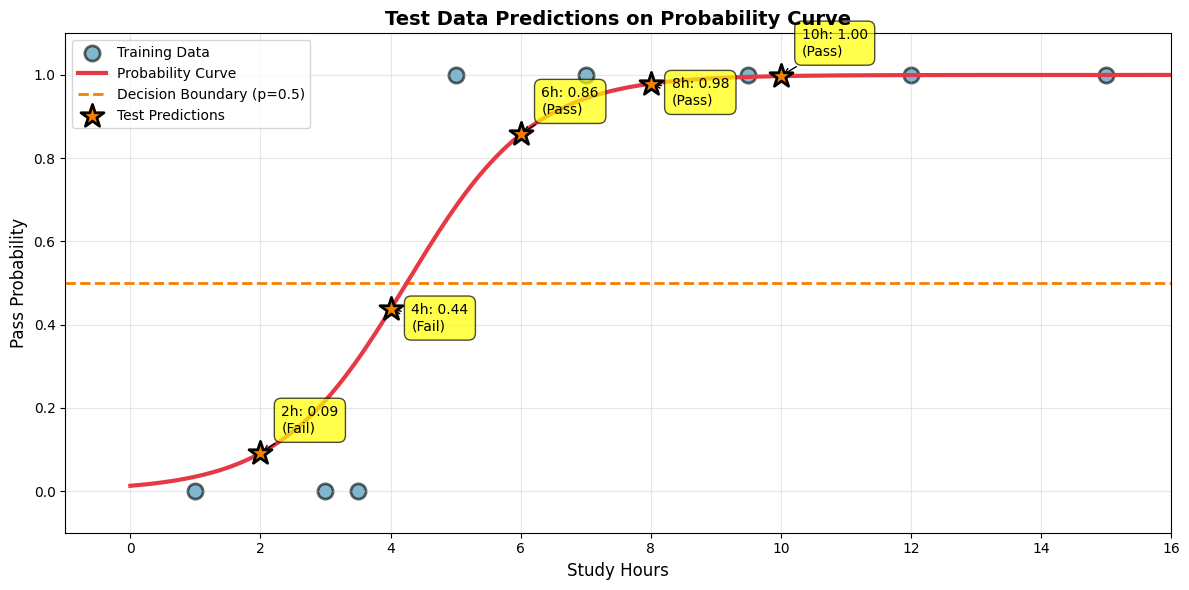

In [25]:
# 새로운 데이터 예측 결과 시각화
plt.figure(figsize=(12, 6))

# 학습 데이터 (원본 그대로)
plt.scatter(x, y, alpha=0.6, s=120, edgecolors='black', linewidth=2, 
            color='#2E86AB', label='Training Data')

# 확률 곡선
plt.plot(x_range, prob_curve, color='#E63946', linewidth=3, 
         label='Probability Curve', zorder=2)

# 결정 경계
plt.axhline(y=0.5, color='#F77F00', linestyle='--', linewidth=2, 
            label='Decision Boundary (p=0.5)', zorder=1)

# 테스트 데이터 예측 결과
test_hours_np = test_hours.numpy()
predicted_probs_np = predicted_probs.numpy()
plt.scatter(test_hours_np, predicted_probs_np, s=300, marker='*', 
            color='#F77F00', edgecolors='black', linewidth=2, 
            label='Test Predictions', zorder=5)

# 테스트 데이터 포인트에 레이블 추가
for i, (hour, prob) in enumerate(zip(test_hours_np, predicted_probs_np)):
    result = "Pass" if prob[0] >= 0.5 else "Fail"
    plt.annotate(f'{hour[0]:.0f}h: {prob[0]:.2f}\n({result})', 
                 xy=(hour[0], prob[0]), 
                 xytext=(15, 15 if i % 2 == 0 else -15), 
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black'))

plt.xlabel('Study Hours', fontsize=12)
plt.ylabel('Pass Probability', fontsize=12)
plt.title('Test Data Predictions on Probability Curve', fontsize=14, fontweight='bold')
plt.xlim(-1, 16)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()